# Проект "Определение стоимости автомобилей"

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. Нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- время обучения модели;
- время предсказания модели.

Сервис предоставил следующие данные:

- `DateCrawled` — дата скачивания анкеты из базы;
- `Price` — цена в евро (целевой признак);
- `VehicleType` — тип автомобильного кузова;
- `RegistrationYear` — год регистрации автомобиля;
- `Gearbox` — тип коробки передач;
- `Power` — мощность (л. с.);
- `Model` — модель автомобиля;
- `Kilometer` — пробег (км);
- `RegistrationMonth` — месяц регистрации автомобиля;
- `FuelType` — тип топлива;
- `Brand` — марка автомобиля;
- `Repaired` — была машина в ремонте или нет;
- `DateCreated` — дата создания анкеты;
- `NumberOfPictures` — количество фотографий автомобиля;
- `PostalCode` — почтовый индекс владельца анкеты (пользователя);
- `LastSeen` — дата последней активности пользователя.

В проекте будет несколько блоков:

- подготовка данных:
    - загрузка данных и изучение общей информации;
    - предобработка данных;
    - исследовательский анализ;
    - корреляционный анализ;
- обучение моделей:
    - модель `DecisionTreeRegressor`;
    - модель `LGBMRegressor`;
    - модель `CatBoostRegressor`;
- анализ моделей;
- вывод.

## Подготовка данных

### Загрузка данных и изучение общей информации

Для начала работы импортируем (установим) все необходимые в прокте библиотеки:

In [1]:
! pip install phik -q

In [2]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import phik
import re

from sklearn.preprocessing import OrdinalEncoder, StandardScaler

from sklearn.impute import SimpleImputer

from sklearn.model_selection import RandomizedSearchCV, train_test_split

from sklearn.pipeline import Pipeline

from sklearn.compose import ColumnTransformer

from sklearn.metrics import root_mean_squared_error

from sklearn.tree import DecisionTreeRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor

Загрузим данные и посмотрим на них:

In [3]:
# Считываем данные и сохраняем в переменную autos
try:
    autos = pd.read_csv('/datasets/autos.csv')
except:
    autos = pd.read_csv('https://code.s3.yandex.net/datasets/autos.csv')
    
# выводим первые 5 строк autos
autos.head(5)

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


Данные считались корректно.

Посмотрим информацию о датафрейме с помощью метода `info()` и количество пропусков в столбцах:

In [4]:
# выводим информацию об autos
display(autos.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  Repaired           283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

None

In [5]:
# выводим количество пропусков по столбцам
autos.isna().sum()

DateCrawled              0
Price                    0
VehicleType          37490
RegistrationYear         0
Gearbox              19833
Power                    0
Model                19705
Kilometer                0
RegistrationMonth        0
FuelType             32895
Brand                    0
Repaired             71154
DateCreated              0
NumberOfPictures         0
PostalCode               0
LastSeen                 0
dtype: int64

Посмотрим на информацию о признаках в датафрейме с помощью метода `describe`:

In [6]:
autos.describe(include='all')

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
count,354369,354369.000000,316879,354369.000000,334536,354369.000000,334664,354369.000000,354369.000000,321474,354369,283215,354369,354369.0,354369.000000,354369
unique,271174,NaN,8,NaN,2,NaN,250,NaN,NaN,7,40,2,109,NaN,NaN,179150
top,2016-03-24 14:49:47,NaN,sedan,NaN,manual,NaN,golf,NaN,NaN,petrol,volkswagen,no,2016-04-03 00:00:00,NaN,NaN,2016-04-06 13:45:54
freq,7,NaN,91457,NaN,268251,NaN,29232,NaN,NaN,216352,77013,247161,13719,NaN,NaN,17
mean,NaN,4416.656776,NaN,2004.234448,NaN,110.094337,NaN,128211.172535,5.714645,NaN,NaN,NaN,NaN,0.0,50508.689087,NaN
std,NaN,4514.158514,NaN,90.227958,NaN,189.850405,NaN,37905.341530,3.726421,NaN,NaN,NaN,NaN,0.0,25783.096248,NaN
min,NaN,0.000000,NaN,1000.000000,NaN,0.000000,NaN,5000.000000,0.000000,NaN,NaN,NaN,NaN,0.0,1067.000000,NaN
25%,NaN,1050.000000,NaN,1999.000000,NaN,69.000000,NaN,125000.000000,3.000000,NaN,NaN,NaN,NaN,0.0,30165.000000,NaN
50%,NaN,2700.000000,NaN,2003.000000,NaN,105.000000,NaN,150000.000000,6.000000,NaN,NaN,NaN,NaN,0.0,49413.000000,NaN
75%,NaN,6400.000000,NaN,2008.000000,NaN,143.000000,NaN,150000.000000,9.000000,NaN,NaN,NaN,NaN,0.0,71083.000000,NaN


Вывод:
- названия столбцов необходимо будет привести к змеиному регистру;
- необходимо будет привести типы данных некоторых столбцов к корректному типу данных;
- в пяти столбцах есть пропуски, необходимо будет их заполнить;
- в столбце `price` есть нули, необходимо проверить много ли таких строк или это один выброс;
- в столбце `RegistrationYear` есть очень странные значения 1000 и 9999, которые не похоже на правду;
- в столбце `Power` тоже есть не реальные значения 0 и 20000, их тоже необходимо будет обработать;
- в столбце `RegistrationMonth` есть нулевой месяц, непорядок;
- в столбце `NumberOfPictures` только нули.

### Предобработка данных

#### Переименование столбцов

Для начала приведем названия столбцов из верблюжьего к змеиному регистру:

In [7]:
# функция для изменения верблюжьего регистра на змеиный
def camel_to_snake(columns):
    col = []
    for i in columns:
        col.append(re.sub('(?<=[a-zA-Z])([A-Z])',('_' + '\g<1>'),i).lower())
    return col

In [8]:
# приведем названия столбцов из верблюжьего к змеиному регистру
autos.columns = camel_to_snake(autos.columns)

# выведем названия столбцов
autos.columns

Index(['date_crawled', 'price', 'vehicle_type', 'registration_year', 'gearbox',
       'power', 'model', 'kilometer', 'registration_month', 'fuel_type',
       'brand', 'repaired', 'date_created', 'number_of_pictures',
       'postal_code', 'last_seen'],
      dtype='object')

Все получилось.

#### Обработка пропусков

Теперь займемся пропусками в столбце `vehicle_type` и `fuel_type`, для начала посмотрим какие уникальные значения вообще есть в столбцах:

In [9]:
# количетсво повторений уникальных значений в столбцах vehicle_type и fuel_type
for i in ['vehicle_type', 'fuel_type']:
    display(autos[i].value_counts())

sedan          91457
small          79831
wagon          65166
bus            28775
convertible    20203
coupe          16163
suv            11996
other           3288
Name: vehicle_type, dtype: int64

petrol      216352
gasoline     98720
lpg           5310
cng            565
hybrid         233
other          204
electric        90
Name: fuel_type, dtype: int64

Есть значение:
- `other` - **другое**;

им и заполним все пропуски:

In [10]:
# заполнение пропусков в столбцах vehicle_type и fuel_type на other
for i in ['vehicle_type', 'fuel_type']:
    autos[i] = autos[i].fillna('other')

Пропуски в `gearbox` и `model` заполним заглушкой `unknown`, т.к. в этих столбцах будет некорректно заполнять пропуски медианой или каким либо значением по комбинации столбцов:

In [11]:
# заполнение пропусков в столбцах gearbox, model на unknown
for i in ['gearbox', 'model']:
    autos[i] = autos[i].fillna('unknown')

Пропуски в столбце `repaired`, заполним значением `no`, т.к. если не указано, что машина бита, скорее всего она не бита:

In [12]:
# заполнение пропусков в столбце repaired на no
autos['repaired'] = autos['repaired'].fillna('no')

In [13]:
# выводим количество пропусков по столбцам
autos.isna().sum()

date_crawled          0
price                 0
vehicle_type          0
registration_year     0
gearbox               0
power                 0
model                 0
kilometer             0
registration_month    0
fuel_type             0
brand                 0
repaired              0
date_created          0
number_of_pictures    0
postal_code           0
last_seen             0
dtype: int64

Все пропуски заполнены!

#### Проверка на наличие явных и неявных дубликатов

Удалим явные дубликаты:

In [14]:
print(f'Размер датафрейма autos до удаления явных дубликатов: {autos.shape}')

# удаление явных дубликатов
autos = autos.drop_duplicates().reset_index(drop=True)

print(f'Размер датафрейма autos после удаления явных дубликатов: {autos.shape}')

Размер датафрейма autos до удаления явных дубликатов: (354369, 16)
Размер датафрейма autos после удаления явных дубликатов: (354364, 16)


Размер датафрейма уменьшился на 5 строк, было 5 явных дубликатов.

Теперь займемся поиском неявных дубликатов, но для начала посмотрим сколько строк с околонулевыми значениями (меньше 5, т.к. такое значение цены уж очень мало, даже для самой "убитой" машины) в столбце с ценой `price`:

In [15]:
print(f'Количество строк с оклонулевой ценой: {autos.query("price <= 5")["price"].count()}')

Количество строк с оклонулевой ценой: 12008


Признак `price` - целевой и заменять околонулевые значения какими-либо другими значениями будет неправильно, т.к. это по сути должна и будет сделать модель, обученная на этих данных, и чтобы "не смущать" модель неинформативными данными, удалим эти строки:

In [16]:
print(f'Размер датафрейма autos до удаления строк: {autos.shape}')

# Удаление строк с нулевой ценой
autos = autos.query('price > 5')

print(f'Размер датафрейма autos после удаления строк: {autos.shape}')

Размер датафрейма autos до удаления строк: (354364, 16)
Размер датафрейма autos после удаления строк: (342356, 16)


Размер датафрейма уменьшился на 12008 строки (3%).

Теперь посмотрим на уникальные значения в столбце `registration_year`

In [17]:
# вывод уникальных значений из столбца registration_year
autos['registration_year'].sort_values().unique()

array([1000, 1001, 1039, 1111, 1234, 1255, 1300, 1400, 1500, 1600, 1602,
       1800, 1910, 1923, 1925, 1927, 1928, 1929, 1930, 1931, 1932, 1933,
       1934, 1935, 1936, 1937, 1938, 1940, 1941, 1942, 1943, 1944, 1945,
       1946, 1947, 1948, 1949, 1950, 1951, 1952, 1953, 1954, 1955, 1956,
       1957, 1958, 1959, 1960, 1961, 1962, 1963, 1964, 1965, 1966, 1967,
       1968, 1969, 1970, 1971, 1972, 1973, 1974, 1975, 1976, 1977, 1978,
       1979, 1980, 1981, 1982, 1983, 1984, 1985, 1986, 1987, 1988, 1989,
       1990, 1991, 1992, 1993, 1994, 1995, 1996, 1997, 1998, 1999, 2000,
       2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011,
       2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2066, 2200, 2222,
       2290, 2500, 2800, 2900, 3000, 3200, 3700, 3800, 4000, 4100, 4500,
       4800, 5000, 5300, 5555, 5600, 5900, 5911, 6000, 7000, 7100, 7800,
       8000, 8200, 8500, 8888, 9000, 9450, 9999])

Года меньше 1910 точно аномалии, тогда машин еще не делали, а чтобы выявить аномальные значения по верхним годам посмотрим на максимальную дату создания анкеты `date_created`:

In [18]:
# вывод самой поздней даты создания анкеты
print(f'Последняя датиа создания анкеты: {autos["date_created"].max()}')

Последняя датиа создания анкеты: 2016-04-07 00:00:00


Последняя анкета была создана в 2016 году, значит строки с годами больше этого - аномалии, избавимся от них:

In [19]:
print(f'Размер датафрейма autos до удаления строк с аномалиями в столбце registration_year: {autos.shape}')

# Удаление строк с аномалиями в столбце registration_year
autos = autos.query('2016 >= registration_year >= 1910')

print(f'Размер датафрейма autos после удаления строк с аномалиями в столбце registration_year: {autos.shape}')

Размер датафрейма autos до удаления строк с аномалиями в столбце registration_year: (342356, 16)
Размер датафрейма autos после удаления строк с аномалиями в столбце registration_year: (328596, 16)


Датафрейм похудел еще на 13760 строки (4%).

Теперь займемся аномалиями в столбце `power`:

In [20]:
# вывод уникальных значений из столбца power
autos['power'].sort_values().unique()

array([    0,     1,     2,     3,     4,     5,     6,     7,     8,
           9,    10,    11,    12,    13,    14,    15,    16,    17,
          18,    19,    20,    21,    22,    23,    24,    25,    26,
          27,    28,    29,    30,    31,    32,    33,    34,    35,
          36,    37,    38,    39,    40,    41,    42,    43,    44,
          45,    46,    47,    48,    49,    50,    51,    52,    53,
          54,    55,    56,    57,    58,    59,    60,    61,    62,
          63,    64,    65,    66,    67,    68,    69,    70,    71,
          72,    73,    74,    75,    76,    77,    78,    79,    80,
          81,    82,    83,    84,    85,    86,    87,    88,    89,
          90,    91,    92,    93,    94,    95,    96,    97,    98,
          99,   100,   101,   102,   103,   104,   105,   106,   107,
         108,   109,   110,   111,   112,   113,   114,   115,   116,
         117,   118,   119,   120,   121,   122,   123,   124,   125,
         126,   127,

Значения мощности автомобиля на заре автомобилестроения конечно были низкими, но тут я предполагаю, что мощность ниже 20 л.с. является аномалией, как и автомобили с мощностью свыше 500 л.с., посмотрим какой процент от всего датафрейма занимают такие аномалии:

In [21]:
print(f'Количество строк с аномальными значениями в power: {autos.query("power > 500 | power < 20")["power"].count()}')

Количество строк с аномальными значениями в power: 33147


Это 10% от всего датафрейма, удалять их не будем, попробуем заменить значения, но для начала заменим эти аномалии на пропуски:

In [22]:
# с помощью среза получаем нужные индексы и заменяем на пропуски
autos.loc[autos.query('power > 500 | power < 20').index, 'power'] = np.nan

print(f'Количество пропусков в столбце power: {autos["power"].isna().sum()}')

Количество пропусков в столбце power: 33147


Количество пропусков совпадает с количеством строк с аномалиями, значит замена прошла корректно, теперь заменим пропуски на медианные значения мощности машин такой же модели:

In [23]:
# Перебираем каждую модель в наборе уникальных значений столбца model
for i in autos['model'].unique():
    # на каждом шаге цикла с помощью атрибута loc выбираем строки, в которых модель i и есть пропуски в power
    # и записываем в них медианное значение power среди моделей i
    autos.loc[(autos['model'] == i) & (autos['power'].isna()), 'power'] = autos.loc[(autos['model'] == i), 'power'].median()    

/opt/conda/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1117: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


Вылезло предупреждение: не нашлось ни одного значения для определения медианы, посмотрим на строки, где не удалось заполнить пропуски:

In [24]:
# вывод строк с пропусками в power
autos.loc[autos['power'].isna()]

,date_crawled,price,vehicle_type,registration_year,gearbox,power,model,kilometer,registration_month,fuel_type,brand,repaired,date_created,number_of_pictures,postal_code,last_seen
234293,2016-03-30 11:39:08,3800,wagon,1978,manual,NaN,serie_1,30000,0,gasoline,land_rover,no,2016-03-30 00:00:00,0,49824,2016-03-30 11:39:08


Всего одна строка, автомобиль "Land Rover serie 1" продавался всего один раз, заполним этот пропуск, поискав информацию в интернете:

In [25]:
# заполнение пропуска в power
autos['power'] = autos['power'].fillna(51)

print(f'Количество пропусков в столбце power: {autos["power"].isna().sum()}')

Количество пропусков в столбце power: 0


Пропусков нет.

Посмотрим на уникальные значения моделей

In [26]:
# вывод уникальных значений из столбца model
autos['model'].sort_values().unique()

array(['100', '145', '147', '156', '159', '1_reihe', '1er', '200',
       '2_reihe', '300c', '3_reihe', '3er', '4_reihe', '500', '5_reihe',
       '5er', '601', '6_reihe', '6er', '7er', '80', '850', '90', '900',
       '9000', '911', 'a1', 'a2', 'a3', 'a4', 'a5', 'a6', 'a8',
       'a_klasse', 'accord', 'agila', 'alhambra', 'almera', 'altea',
       'amarok', 'antara', 'arosa', 'astra', 'auris', 'avensis', 'aveo',
       'aygo', 'b_klasse', 'b_max', 'beetle', 'berlingo', 'bora',
       'boxster', 'bravo', 'c1', 'c2', 'c3', 'c4', 'c5', 'c_klasse',
       'c_max', 'c_reihe', 'caddy', 'calibra', 'captiva', 'carisma',
       'carnival', 'cayenne', 'cc', 'ceed', 'charade', 'cherokee',
       'citigo', 'civic', 'cl', 'clio', 'clk', 'clubman', 'colt', 'combo',
       'cooper', 'cordoba', 'corolla', 'corsa', 'cr_reihe', 'croma',
       'crossfire', 'cuore', 'cx_reihe', 'defender', 'delta', 'discovery',
       'doblo', 'ducato', 'duster', 'e_klasse', 'elefantino', 'eos',
       'escort', 'espac

Есть два одинаковых значения:
- `rangerover`;
- `range_rover`.

Зааменим `rangerover` на `range_rover`:

In [27]:
# замена rangerover на range_rover
autos['model'] = autos['model'].replace('rangerover', 'range_rover')

print('Размер среза датафрейма по модели "rangerover":', autos.query('model == "rangerover"').shape)

Размер среза датафрейма по модели "rangerover": (0, 16)


Ноль строк, замена прошла успешно.

Посмотрим на количество строк при группировке по признаку `registration_month`

In [28]:
# вывод количества строк по уникальным значениям registration_month
autos['registration_month'].value_counts()

3     32637
6     29697
0     28940
4     27605
5     27496
7     25736
10    24768
11    22956
12    22870
9     22628
1     21858
8     21319
2     20086
Name: registration_month, dtype: int64

Почти 30 тыс записей датированы нулевым месяцем, посмотрим на количество нулевых месяцев по годам:

In [29]:
# создадим сводную таблицу по столбцам registration_year и registration_month и посчитаем количество строк
# срежем только нулевой месяц и выведем случайные 15 строк
autos.pivot_table(index=['registration_year', 'registration_month'], 
                  aggfunc='count')\
    .query('registration_month == 0')\
    ['price']\
    .sample(15, random_state=42)

registration_year  registration_month
1932               0                        1
1975               0                       17
1941               0                        1
1910               0                       38
1985               0                      187
1987               0                       86
2006               0                      746
1993               0                      479
1990               0                      664
1968               0                       10
2008               0                      448
2014               0                       36
1956               0                        4
1950               0                        2
1998               0                     1955
Name: price, dtype: int64

Нулевой месяц присутствует во всех годах, заменить его чем-то корректным не получится, поэтому оставим этот нулевой месяц, как-то смутить модель у него не получится, т.к. он присутствует везде.

Посмотрим на уникальные значения в столбце `fuel_type`

In [30]:
# вывод уникальных значений из столбца fuel_type
autos['fuel_type'].sort_values().unique()

array(['cng', 'electric', 'gasoline', 'hybrid', 'lpg', 'other', 'petrol'],
      dtype=object)

`petrol` и `gasoline` одно и тоже, заменим `gasoline` на `petrol`:

In [31]:
# замена gasoline на petrol
autos['fuel_type'] = autos['fuel_type'].replace('gasoline', 'petrol')

# вывод уникальных значений из столбца fuel_type
autos['fuel_type'].sort_values().unique()

array(['cng', 'electric', 'hybrid', 'lpg', 'other', 'petrol'],
      dtype=object)

Избавились от синонимов.

Проверим уникальные значения в столбце `brand`:

In [32]:
# вывод уникальных значений из столбца brand
autos['brand'].sort_values().unique()

array(['alfa_romeo', 'audi', 'bmw', 'chevrolet', 'chrysler', 'citroen',
       'dacia', 'daewoo', 'daihatsu', 'fiat', 'ford', 'honda', 'hyundai',
       'jaguar', 'jeep', 'kia', 'lada', 'lancia', 'land_rover', 'mazda',
       'mercedes_benz', 'mini', 'mitsubishi', 'nissan', 'opel', 'peugeot',
       'porsche', 'renault', 'rover', 'saab', 'seat', 'skoda', 'smart',
       'sonstige_autos', 'subaru', 'suzuki', 'toyota', 'trabant',
       'volkswagen', 'volvo'], dtype=object)

Неявных дубликатов нет, все хорошо.

Проверим уникальные значения в столбце `number_of_pictures`:

In [33]:
# вывод уникальных значений из столбца number_of_pictures
autos['number_of_pictures'].sort_values().unique()

array([0])

В столбце только нули, информации ноль поэтому удалим этот столбец из датафрема:

In [34]:
# удаление столбца number_of_pictures
autos = autos.drop('number_of_pictures', axis=1)

print(f'Размер датафрема autos: {autos.shape}')

Размер датафрема autos: (328596, 15)


Датафрейм уменьшился на один столбец.

Посмотрим на период, когда создавались анкеты:

In [35]:
print(f'Анкеты создавались с {autos["date_created"].min()} по {autos["date_created"].max()}')

Анкеты создавались с 2014-03-10 00:00:00 по 2016-04-07 00:00:00


Период получился чуть больше двух лет, за такой малый период цены не должны были сильно поменяться, поэтому можно убрать этот столбец `date_created`, а также можно убрать столбцы `date_crawled` (дата скачивания анкеты из базы) и `last_seen` (дата последней активности пользователя), т.к. они на ценообразование они вообще не влияют:

In [36]:
# удаление признаков не влияющих на ценообразование
autos = autos.drop(['date_crawled', 'date_created', 'last_seen'], axis=1)

print(f'Размер датафрема autos: {autos.shape}')

Размер датафрема autos: (328596, 12)


Датафрейм уменьшился еще на три столбца.

Можно еще раз проверить на наличие явных дубликатов:

In [37]:
print(f'Количество явных дубликатов в autos: {autos.duplicated().sum()}')

Количество явных дубликатов в autos: 22412


Появилось еще 22412 дубликатов, удалим их:

In [38]:
# удаление явных дубликатов
autos = autos.drop_duplicates().reset_index(drop=True)

print(f'Размер датафрейма autos после второго удаления явных дубликатов: {autos.shape}')

Размер датафрейма autos после второго удаления явных дубликатов: (306184, 12)


#### Замена типов данных

Для категориальных признаков (`vehicle_type`, `gearbox`, `model`, `fuel_type`, `brand`, `repaired`) заменим тип данных с `object` на `category`, для облегчения файла:

In [39]:
# замена типа данных столбцов
autos[['vehicle_type', 'gearbox', 'model', 'fuel_type', 'brand', 'repaired']] = \
autos[['vehicle_type', 'gearbox', 'model', 'fuel_type', 'brand', 'repaired']].astype('category')

In [40]:
# вывод информации о датафрейме
autos.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 306184 entries, 0 to 306183
Data columns (total 12 columns):
 #   Column              Non-Null Count   Dtype   
---  ------              --------------   -----   
 0   price               306184 non-null  int64   
 1   vehicle_type        306184 non-null  category
 2   registration_year   306184 non-null  int64   
 3   gearbox             306184 non-null  category
 4   power               306184 non-null  float64 
 5   model               306184 non-null  category
 6   kilometer           306184 non-null  int64   
 7   registration_month  306184 non-null  int64   
 8   fuel_type           306184 non-null  category
 9   brand               306184 non-null  category
 10  repaired            306184 non-null  category
 11  postal_code         306184 non-null  int64   
dtypes: category(6), float64(1), int64(5)
memory usage: 16.1 MB


Замена типов данных прошла успешно!

#### Вывод по блоку

Выводы по предобработке данных:
- названия столбцов приведены к змеиному регистру;
- обработаны пропуски в столбцах:
    - пропуски в столбцах `vehicle_type` и `fuel_type` заполнены значением `other`;
    - пропуски в столбцах `gearbox` и `model` заполнены значением-заглушкой `unknown`;
    - пропуски в столбце `repaired` заполнены значением `no`;
- обработаны аномальные значения в столбцах `price`, `registration_year`, `power`;
- из датафрйема убраны столбцы, не имеющие влияния на ценообразование:
    - `date_crawled` - дата скачивания анкеты из базы, показывет только дату выгрузки анкеты и только;
    - `date_created` - дата создания анкеты, могла бы влиять на ценообразование, если бы период был больше хотя бы 5 лет;
    - `last_seen` - дата последней активности пользователя, показывает только активность пользователя к ценообразованию также отношения не имеет;
    - `number_of_pictures` - количество фотографий автомобиля, столбец состоял только из нулей, возможно при выгрузке произошла ошибка;
- удалены явные дубликаты;
- категориальным признакам присвоен тип данных `category`;
- после предобработки данных датафрейм изменился:
    - количество строк уменьшилось на 48185 (13,6%);
    - количество столбцов уменьшилось на 4;
    - размер файла уменьшился с 43,3 МВ до 16,1 МВ.

### Исследовательский анализ

#### Исследовательский анализ количественных признаков

Для анализа количественных признаков будем строить гистограммы (барплот) и "ящики с усами", предварительно создадим функцию для их построения:

In [41]:
# функция для построения гистограммы (барплота) и ящика с усами для количетсвенных признаков
def hist_and_boxplot_num_col (df, parametr, type_plot):
    # df - датафрейм
    # pframetr - признак
    # type_plot - тип графика bar или hist
    
    # вывод числового описания данных
    print(df[parametr].describe())
    
    # выбор количества корзин
    if ((len(df[parametr].unique())) >= 30):
        bins = 30
    else:
        bins = len(df[parametr].unique())
    
    # построение фигур для графиков
    fig, axes = plt.subplots(1, 2, figsize=(18, 9))
    plt.suptitle(f'Распределение признака {parametr}', fontsize=20)
    
    # построение гистограммы
    if type_plot == 'hist':
        df[parametr].hist(bins=20, grid=True, ax=axes[0])
        axes[0].set_ylabel('Количество', fontsize=15)
        axes[0].set_xlabel(f'Значение {parametr}', fontsize=15)
    # или столбчатого графика
    elif type_plot == 'bar':
        df.groupby(by=parametr)[parametr].count().plot.bar(grid=True, ax=axes[0])
        axes[0].set_ylabel('Количество', fontsize=15)
        axes[0].set_xlabel(f'Значение {parametr}', fontsize=15)
    else:
        print('Неизвестный тип графика')
        
    # построение ящика с усами
    df.boxplot(column=parametr, ax=axes[1])
    axes[1].set_ylabel(f'Значение {parametr}', fontsize=15)
    
    plt.show()

Посмотрим как распеределена цена `price` (целевой признак):

count    306184.000000
mean       4581.920447
std        4539.621658
min           7.000000
25%        1200.000000
50%        2900.000000
75%        6500.000000
max       20000.000000
Name: price, dtype: float64


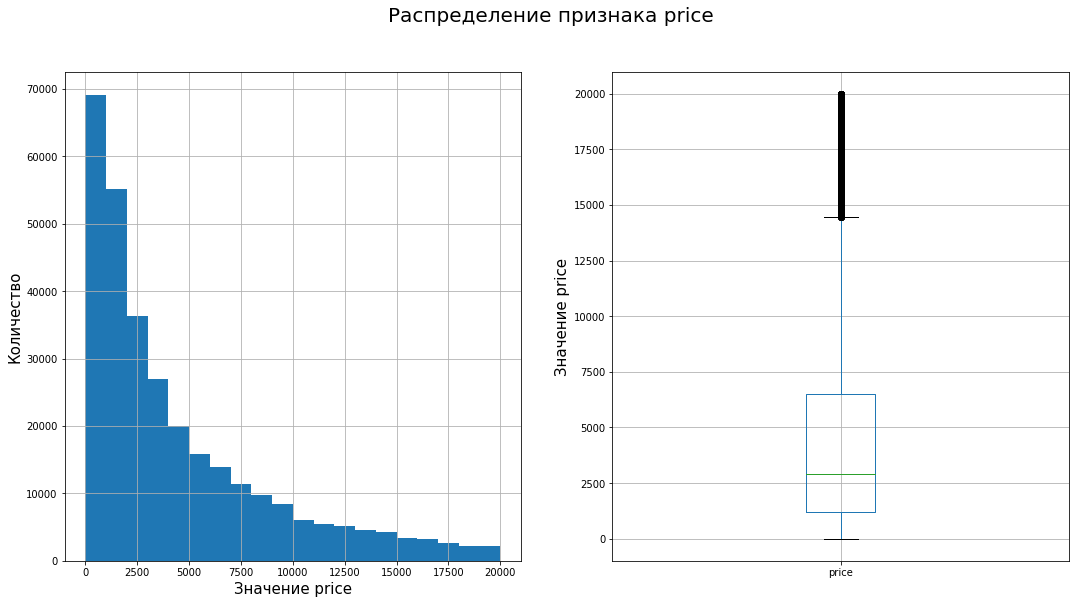

In [42]:
# построение гистограммы и ящика с усами для price
hist_and_boxplot_num_col (autos, 'price', 'hist')

По графикам видно, что:
- чем дороже автомобиль, тем их меньше;
- среднее значение цены (4565) больше чем медианное (2899);
- есть много значений за пределами "верхнего уса", но это не выбросы.

Теперь посмотрим как распеределен год выпуска авто `registration_year`:

count    306184.000000
mean       2002.554500
std           6.949318
min        1910.000000
25%        1999.000000
50%        2003.000000
75%        2007.000000
max        2016.000000
Name: registration_year, dtype: float64


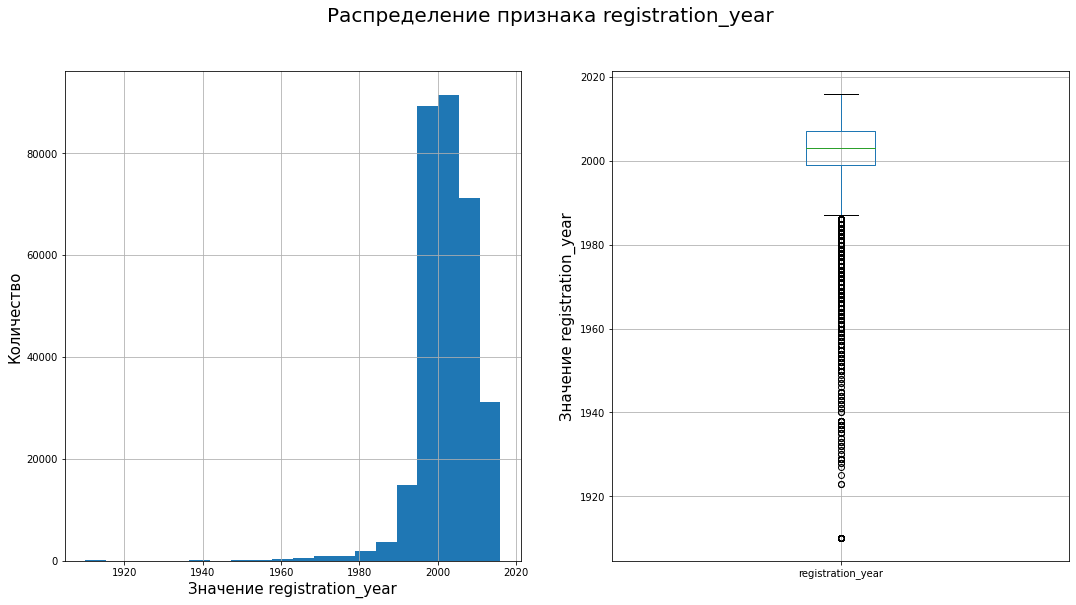

In [43]:
# построение гистограммы и ящика с усами для registration_year
hist_and_boxplot_num_col (autos, 'registration_year', 'hist')

По графикам видно, что:
- продавались автомобили в основном года выпуска с 1999 по 2016, более старых автомобилей (выпущенных раньше 1990 года) продавалось единицы (не выбросы).

Посмотрим на распределение месяца выпуска машин `registration_month`:

count    306184.000000
mean          5.801943
std           3.679948
min           0.000000
25%           3.000000
50%           6.000000
75%           9.000000
max          12.000000
Name: registration_month, dtype: float64


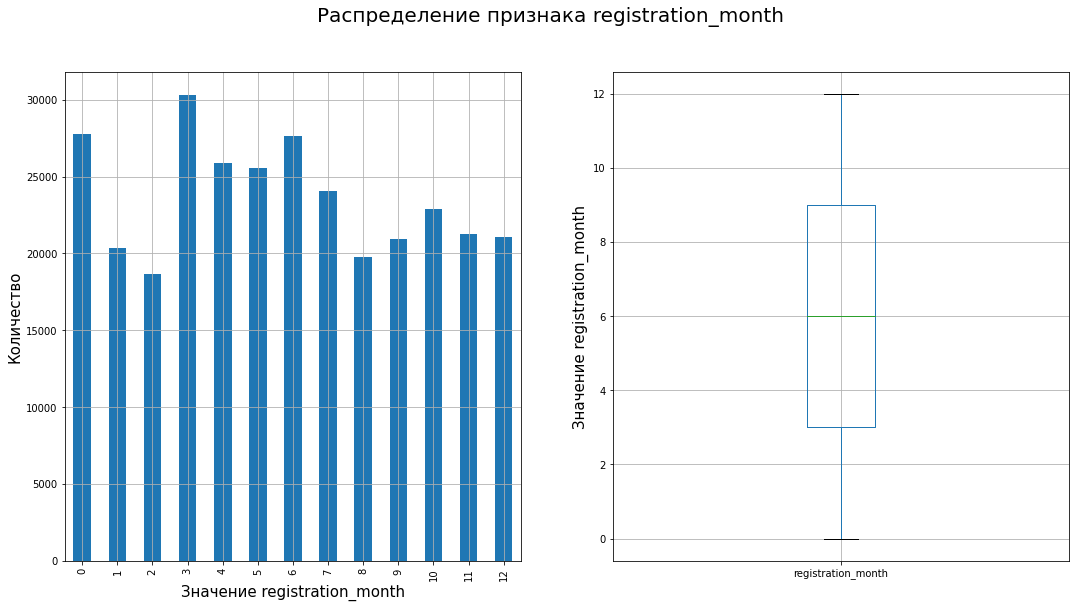

In [44]:
# построение барплота и ящика с усами для registration_month
hist_and_boxplot_num_col (autos, 'registration_month', 'bar')

По графикам видно, что:
- несмотря на то, что месяцев 13, весной и в начале лета выпускалось больше машин, чем в остальные месяцы.

Посмотрим на распределение автомобилей по мощности `power`:

count    306184.000000
mean        119.069488
std          52.076492
min          20.000000
25%          75.000000
50%         110.000000
75%         144.000000
max         500.000000
Name: power, dtype: float64


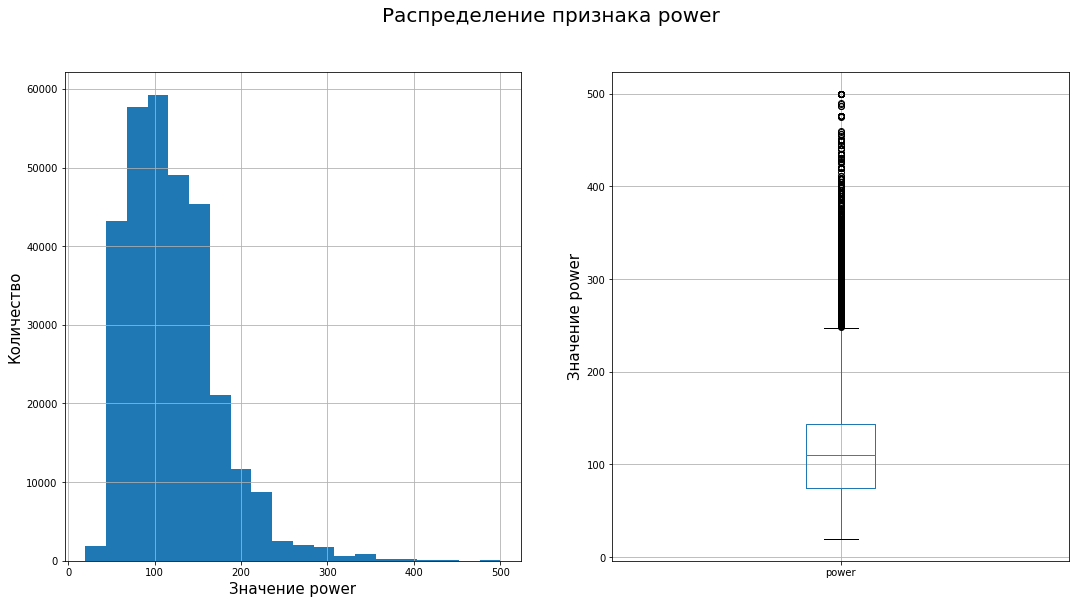

In [45]:
# построение гистограммы и ящика с усами для power
hist_and_boxplot_num_col (autos, 'power', 'hist')

По графикам видно, что:
- в основном афтомобили продавали с мощьностью от 75 до 200 л.с. и совсем малая часть машин с мощьностью свыше 250 л.с.

Посмотрим на распределение пробега `kilometer`:

count    306184.000000
mean     128324.732840
std       37458.570274
min        5000.000000
25%      125000.000000
50%      150000.000000
75%      150000.000000
max      150000.000000
Name: kilometer, dtype: float64


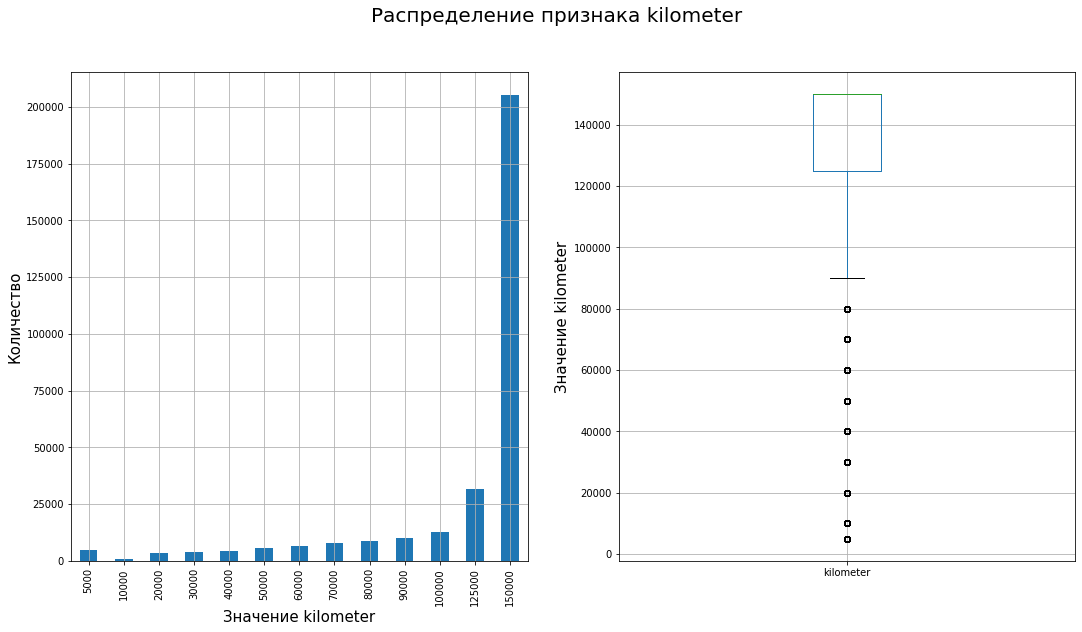

In [46]:
# построение барплота и ящика с усами для kilometer
hist_and_boxplot_num_col (autos, 'kilometer', 'bar')

По графикам видно, что:
- по пробегу автомобили были поделены на категории, и самая многочисленная 150000 км.

Посмотрим на распределение признака почтовый индекс `postal_code`:

count    306184.000000
mean      50953.930646
std       25786.324210
min        1067.000000
25%       30625.000000
50%       49716.000000
75%       71672.000000
max       99998.000000
Name: postal_code, dtype: float64


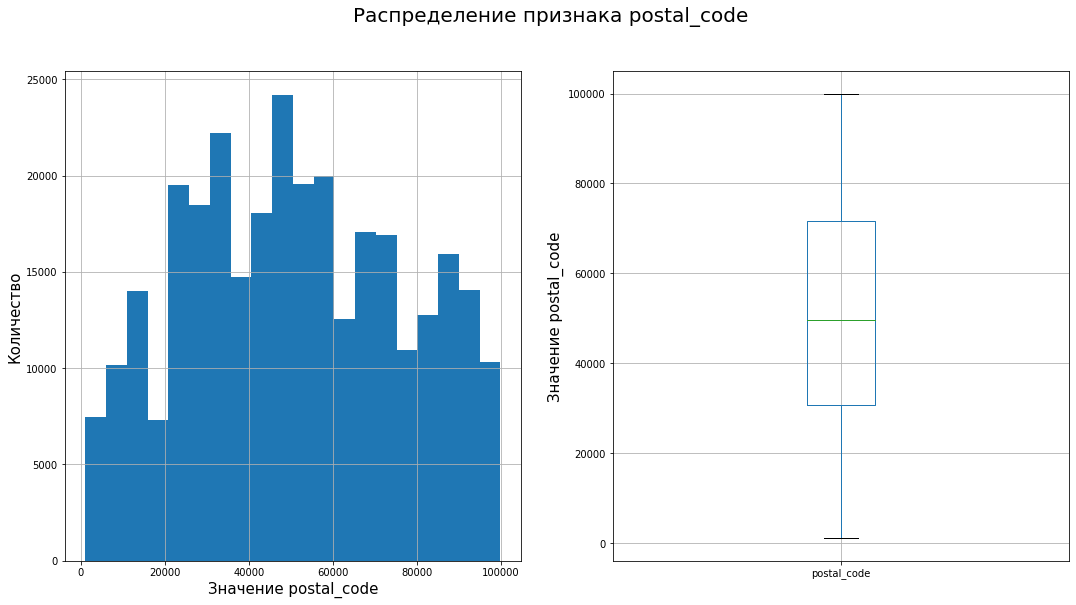

In [47]:
# построение гистограммы и ящика с усами для postal_code
hist_and_boxplot_num_col (autos, 'postal_code', 'hist')

По графикам видно, что:
- если за каждым почтовым индексом скрывается какой-нибудь регион/город, то автомобили представлены со всех регионов.

#### Исследовательский анализ категориальных признаков

Сначала также создадим функцию, которая будет строить графики для категориальных переменных:

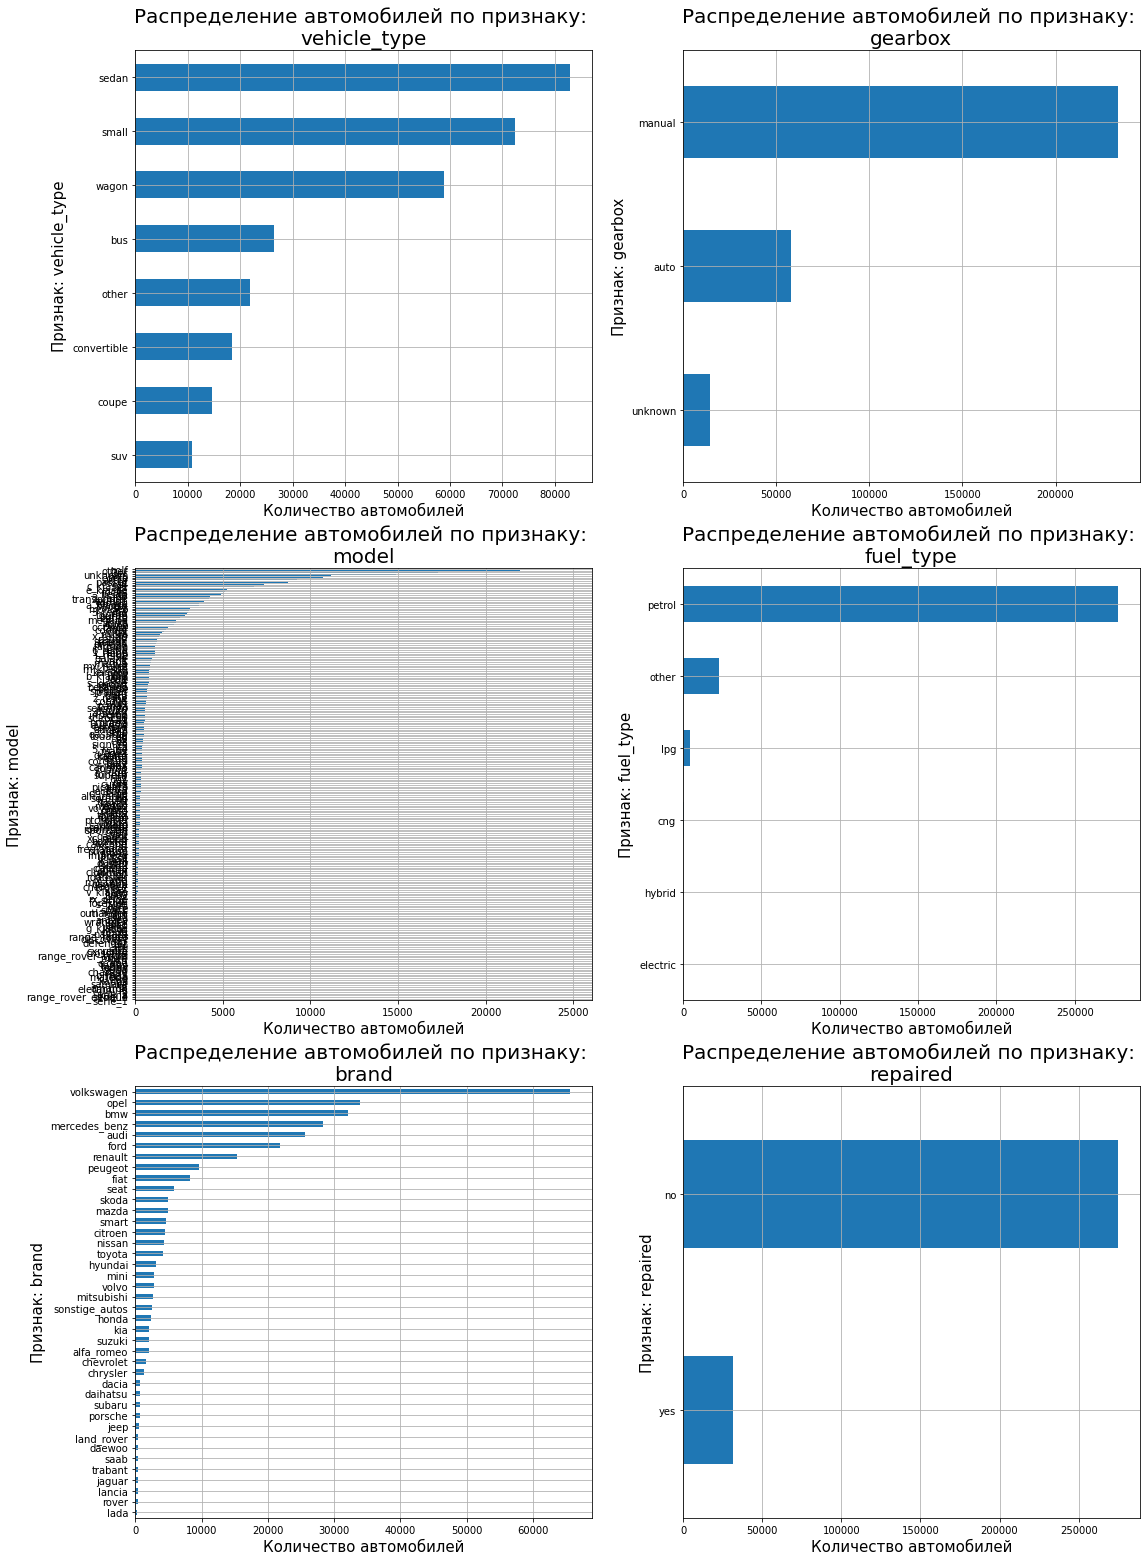

In [48]:
# создание фигуры для графиков
fig, axes = plt.subplots(3, 2, figsize=(18, 27))
 
# построение барплота для категориальных признаков
for i, j in zip(list(autos.select_dtypes('category')), range(6)):
    autos.groupby(by=i)[i].count().sort_values().plot.barh(
        grid=True,
        ax=axes[j // 2, j % 2]
    )
    axes[j // 2, j % 2].set_xlabel('Количество автомобилей', fontsize=15)
    axes[j // 2, j % 2].set_ylabel(f'Признак: {i}', fontsize=15)
    axes[j // 2, j % 2].set_title(f'Распределение автомобилей по признаку: \n{i}', fontsize=20)

По графикам видно, что:
- больше всех машин с типом кузова : `sedan`, `small`, `wagon`;
- машин с ручной КПП больше примерно в 4 раза;
- каких моделей больше всех непонятно, но судя по распределению `brand` там модели немецкий производителей;
- больше всех бензиновых моторов;
- в основном объявления немецких авто;
- большинство машин не биты.

#### Вывод по блоку

Вывод по исследовательскому анализу:
- в датафрейме представлены в основном не битые, бензиновые, с ручной КПП, в кузове `sedan`, `small` или `wagon` машины немецкого автопрома, с ценой до 6500, мощностью до 200 л.с., с пробегом 150000 км., с годом выпуска с 1999 по 2016;

### Корреляционный анализ

Для нахождения зависимостей признаков воспользуемся коэффициентом Фи в параметре `interval_cols`, отобразим непрерывные признаки (признаки `registration_year`, `kilometer` и `registration_month` по сути своей похожи на категориальные, не будем их указывать как непрерывные):


<div class="alert alert-block alert-success">
<b>Успех:</b> Как всегда - хорошее решение использовать phik, для нахождения не только линейных зависимостей и не только для количественных данных
</div>


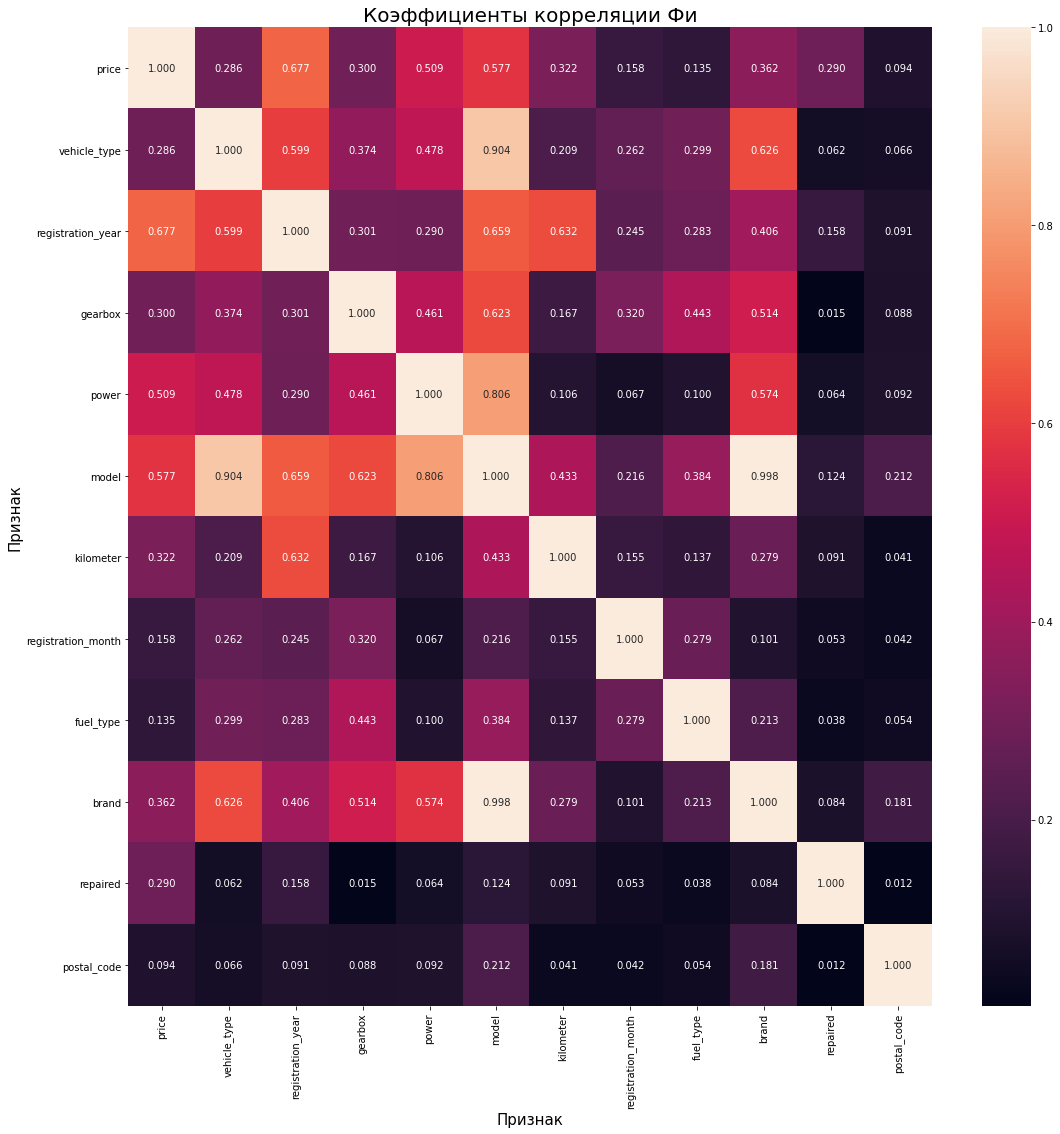

In [49]:
# создание фигуры для тепловой карты
plt.subplots(figsize=(18, 18))

# тепловая карта коэффициентов корреляции Фи
sns.heatmap(autos
            .phik_matrix(interval_cols=['price', 'power', 'postal_code']), 
            annot=True, 
            fmt=".3f")
plt.ylabel('Признак', fontsize=15)
plt.xlabel('Признак', fontsize=15)
plt.title('Коэффициенты корреляции Фи', fontsize=20)
plt.show()

По тепловой карте видно, что:
- целевой признак `price` средне коррелирует с годом регистрации автомобиля `registration_year` (коэффициент Фи 0,677), немного меньше коррелируют признаки модель `model` и мощность `power` (коэффициент Фи 0,577 и 0,508 соответственно);
- дальше идет несколько признаков со слабой корреляцией: `vehicle_type`, `gearbox`, `kilometer`, `brand` и `repaired` (коэффицент корреляции Фи от 0,287 до 0,361);
- практически не коррелируют с целевым признаком: `registration_month`, `fuel_type` и `postal_code`;
- наблюдается мультиколлинеарность между признаками `model` и `brand`, оно и понятно у разных марок не бывает одинаковых моделей машин, избавимся от нее объединив два этих признака в один:

In [50]:
# добавление нового признака brand_model
autos['brand_model'] = autos['brand'].astype('str') + str('_') + autos['model'].astype('str')

# присвоение признаку brand_model категориальный тип данных
autos['brand_model'] = autos['brand_model'].astype('category')

print(f' Количество пропусков в brand_model: {autos["brand_model"].isna().sum()}')

 Количество пропусков в brand_model: 0


In [51]:
# удаление признаков model и brand
autos = autos.drop(['model', 'brand'], axis=1)

print(f'Размер датафрейма autos: {autos.shape}')

Размер датафрейма autos: (306184, 11)


Создание нового признака прошло успешно, пропусков нет, размер датафрейма уменьшился на 1 признак, посмотрим на его коэффициент корреляции Фи

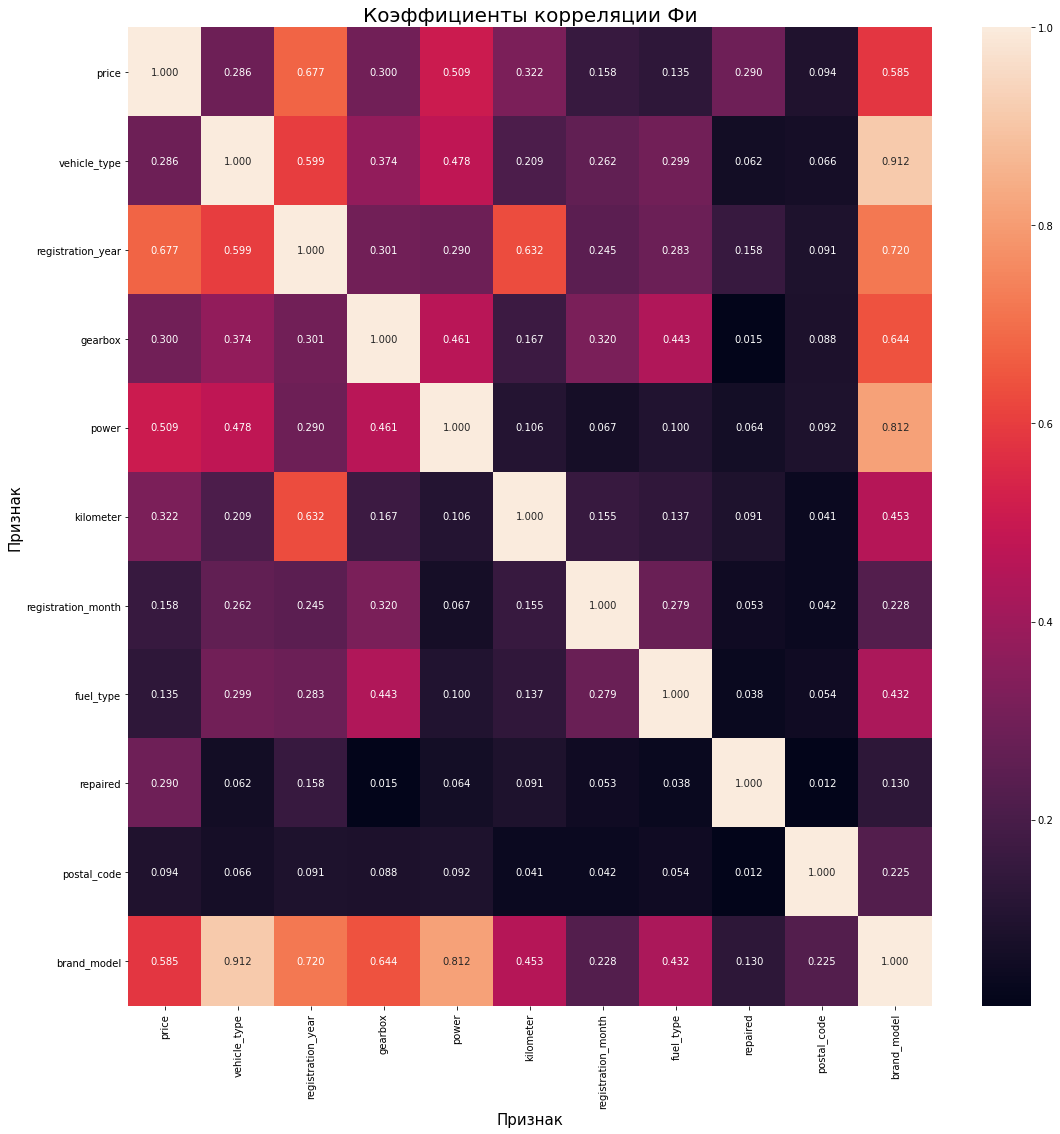

In [52]:
# создание фигуры для тепловой карты
plt.subplots(figsize=(18, 18))

# тепловая карта коэффициентов корреляции Фи
sns.heatmap(autos
            .phik_matrix(interval_cols=['price', 'power', 'postal_code']), 
            annot=True, 
            fmt=".3f")
plt.ylabel('Признак', fontsize=15)
plt.xlabel('Признак', fontsize=15)
plt.title('Коэффициенты корреляции Фи', fontsize=20)
plt.show()

Было два признака и корреляцией 0,577 и 0,362, стал один с коэффициентом корреляции Фи 0,585, немного лучше и то хорошо.

Новый признак сильно коррелирует с `vehicle_type` и `power`, но о мультиколлинеарности речи не идет.

## Обучение моделей

### Подготовка данных

Разделим датафрейм на тренировочную, валидационную и тестовую выбоки, в пропорции 3:1:1:

In [53]:
# разделение на тренировочную и валидационно-тестовую выборки
X_train, X_valid_test, y_train, y_valid_test = train_test_split(
    autos.drop('price', axis=1),
    autos['price'],
    test_size = 0.4, 
    random_state = 42
)

In [54]:
# разделение на валидационную и тестовую выборки
X_valid, X_test, y_valid, y_test = train_test_split(
    X_valid_test,
    y_valid_test,
    test_size = 0.5, 
    random_state = 42
)

In [55]:
print(f'''
Размер тренировочной выборки X_train: {X_train.shape}
Размер тренировочного целевого признака y_train: {y_train.shape}
Размер валидационной выборки X_valid: {X_valid.shape}
Размер валидационного целевого признака y_valid: {y_valid.shape}
Размер тестовой выборки X_test: {X_test.shape}
Размер тестового целевого признака y_test: {y_test.shape}
''')


Размер тренировочной выборки X_train: (183710, 10)
Размер тренировочного целевого признака y_train: (183710,)
Размер валидационной выборки X_valid: (61237, 10)
Размер валидационного целевого признака y_valid: (61237,)
Размер тестовой выборки X_test: (61237, 10)
Размер тестового целевого признака y_test: (61237,)



### Модель DecisionTreeRegressor

Создадим списки с количественными и категориальными признаками:

In [56]:
# список с категориальными признаками
ord_columns = ['vehicle_type', 'gearbox', 'fuel_type', 'repaired', 'brand_model']

# список с количественными признаками
num_columns = ['registration_year', 'power', 'kilometer', 'registration_month', 'postal_code']

Создадим пайплайн для кодирования данных с помощью `OrdinalEncoder()`:

In [57]:
# пайплайн для кодирования данных
ord_pipe = Pipeline(
    [
        (
            'simpleImputer_before_ord', 
            SimpleImputer(missing_values=np.nan, strategy='most_frequent')
        ),
        (
            'ord',  
            OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=np.nan)
        ),
        (
            'simpleImputer_after_ord', 
            SimpleImputer(missing_values=np.nan, strategy='most_frequent')
        )
    ]
)

Объединим пайплайн для кодирования в общий пайплайн подготовки данных вместе с масштабированием данных (`StandardScaler()`):

In [58]:
# пайплайн подготовки данных
data_preprocessor = ColumnTransformer(
    [
        ('ord', ord_pipe, ord_columns),
        ('num', StandardScaler(), num_columns)
    ], 
    remainder='passthrough'
)

Получим отмасштабированные и закодированные данные:

In [59]:
# получение из пайплайна тренировочной выборки
X_train_model_1 = pd.DataFrame(
    data_preprocessor.fit_transform(X_train),
    columns=data_preprocessor.get_feature_names_out()
)

# получение из пайплайна валидационной выборки
X_valid_model_1 = pd.DataFrame(
    data_preprocessor.transform(X_valid),
    columns=data_preprocessor.get_feature_names_out()    
)

print(f'''
Размер тренировочной выборки X_train_model_1: {X_train_model_1.shape}
Размер валидационной выборки X_valid_model_1: {X_valid_model_1.shape}
''')


Размер тренировочной выборки X_train_model_1: (183710, 10)
Размер валидационной выборки X_valid_model_1: (61237, 10)



Размер выборок не изменился.

Теперь можно инициализировать модель `DecisionTreeRegressor` и создать словарь с гиперпараметрами: 

In [60]:
# инициализируем модель дерева решений
model_1 = DecisionTreeRegressor(random_state=42)

In [61]:
# гиперпараметры для DecisionTreeRegressor
parameters_model_1 = {
    'max_depth': range(10, 21, 5), # ограничение максимальной глубины дерева
    'max_features': ['sqrt', 'log2', None], # число листьев
    'min_samples_leaf': [1, 3, 5] # минимальное число объектов в листе
}

Теперь создадим функцию для выбора лучшей модели с помощью `RandomizedSearchCV`, выберем лучшую модель:

In [62]:
# функция для выбора лучшей модели
def best_model (model, parameters, X_train, y_train):
    # model - модель
    # parameters - гиперпараметры
    # X_train - тренировочная выборка
    # y_train - целевой признак
    
    # выбор лучшей модели с помощью RandomizedSearchCV
    rs = RandomizedSearchCV(
        model,
        parameters,
        random_state=42,
        cv=5,
        n_jobs=-1,
        scoring='neg_root_mean_squared_error'
    )

    # запуск поиска гиперпараметров
    rs.fit(X_train, y_train) 

    print(f'''
    Лучшие гиперпараметры: {rs.best_params_}
    Лучшая метрика RMSE: {round(-rs.best_score_, 2)}
    ''')
    
    # возвращает лучшую модель
    return rs.best_estimator_

In [63]:
# выбор лучшей модели DecisionTreeRegressor
model_1 = best_model(model_1, parameters_model_1, X_train_model_1, y_train)


    Лучшие гиперпараметры: {'min_samples_leaf': 5, 'max_features': None, 'max_depth': 15}
    Лучшая метрика RMSE: 1959.61
    


Параметры лучшей модели `DecisionTreeRegressor` получились следующие:
- максимальная глубина дерева `max_depth` - 15;
- максимальное число листьев `max_features` - none (не ограничено);
- минимальное число объектов в листе `min_samples_leaf` - 5;
- лучшая метрика `RMSE` при кросс-валидации - 1959,61.

Обучим лучшую модель на тренировочной выборке:

In [64]:
%%time
# обучение модели на тренировочных данных
model_1.fit(X_train_model_1, y_train)

CPU times: user 729 ms, sys: 0 ns, total: 729 ms
Wall time: 734 ms


DecisionTreeRegressor(max_depth=15, min_samples_leaf=5, random_state=42)

Модель обучилась за 788 ms, быстро, теперь получим предсказания на валидационной выборке:

In [65]:
%%time
# получение предсказаний
y_pred_model_1 = model_1.predict(X_valid_model_1)

CPU times: user 13.6 ms, sys: 10 µs, total: 13.6 ms
Wall time: 23.7 ms


In [66]:
print(f'Метрика RMSE на валидационной выборке: {round(root_mean_squared_error(y_valid, y_pred_model_1), 2)}')

Метрика RMSE на валидационной выборке: 1955.07


Модель `DecisionTreeRegressor` показала следующие результаты:
- качество предсказания (метрика `RMSE`): 1955,07;
- время обучения модели: 0,788 сек;
- время предсказания модели: 0,013 сек.

### Модель LGBMRegressor

Получим тренировочную и валидационную выборки для модели `LGBMRegressor`:

In [67]:
# тренировочная и валидационная выборки для модели LGBMRegressor
X_train_model_2 = X_train.copy()
X_valid_model_2 = X_valid.copy()

print(f'''
Размер тренировочной выборки X_train_model_2: {X_train_model_2.shape}
Размер валидационной выборки X_valid_model_2: {X_valid_model_2.shape}
''')


Размер тренировочной выборки X_train_model_2: (183710, 10)
Размер валидационной выборки X_valid_model_2: (61237, 10)



Все хорошо, теперь инициализируем модель `LGBMRegressor` и создадим словарь с гиперпараметрами: 

In [68]:
# инициализируем модель LGBMRegressor
model_2 = LGBMRegressor(random_state=42)

In [69]:
# гиперпараметры для LGBMRegressor
parameters_model_2 = {
    'num_leaves': range(10, 21, 5), # максимальное число листьев
    'max_depth': range(10, 13), # максимальная глубина дерева
    'n_estimators': [50, 100] # количество итераций
}

Теперь с помощью функции `best_model` выберем лучшую модель `LGBMRegressor`:

In [70]:
# выбор лучшей модели LGBMRegressor
model_2 = best_model(model_2, parameters_model_2, X_train_model_2, y_train)


    Лучшие гиперпараметры: {'num_leaves': 20, 'n_estimators': 100, 'max_depth': 10}
    Лучшая метрика RMSE: 1716.02
    


Параметры лучшей модели `LGBMRegressor` получились следующие:
- максимальное число листьев `num_leaves` - 20;
- максимальная глубина дерева `max_depth` - 10;
- количество итераций `n_estimators` - 100;
- лучшая метрика `RMSE` при кросс-валидации - 1716,02.

Обучим лучшую модель на тренировочной выборке:

In [71]:
%%time
# обучение модели на тренировочных данных
model_2.fit(X_train_model_2, y_train)

CPU times: user 3.67 s, sys: 12.2 ms, total: 3.68 s
Wall time: 3.79 s


LGBMRegressor(max_depth=10, num_leaves=20, random_state=42)

Модель обучилась за 4.9 s, медленне чем `DecisionTreeRegressor`, теперь получим предсказания:

In [72]:
%%time
# получение предсказаний
y_pred_model_2 = model_2.predict(X_valid_model_2)

CPU times: user 526 ms, sys: 0 ns, total: 526 ms
Wall time: 588 ms


In [73]:
print(f'Метрика RMSE на тестовой выборке: {round(root_mean_squared_error(y_valid, y_pred_model_2), 2)}')

Метрика RMSE на тестовой выборке: 1701.5


Модель `LGBMRegressor` показала следующие результаты:
- качество предсказания (метрика `RMSE`): 1701.5;
- время обучения модели: 4.9 сек;
- время предсказания модели: 0,601 сек.

### Модель CatBoostRegressor

Получим тренировочную и валидационную выборки для модели `CatBoostRegressor`:

In [74]:
# тренировочная и валидационная выборки для модели LGBMRegressor
X_train_model_3 = X_train_model_1.copy()
X_valid_model_3 = X_valid_model_1.copy()

print(f'''
Размер тренировочной выборки X_train_model_3: {X_train_model_3.shape}
Размер валидационной выборки X_valid_model_3: {X_valid_model_3.shape}
''')


Размер тренировочной выборки X_train_model_3: (183710, 10)
Размер валидационной выборки X_valid_model_3: (61237, 10)



Все хорошо, теперь инициализируем модель `CatBoostRegressor` и создадим словарь с гиперпараметрами:

In [75]:
# инициализируем модель CatBoostRegressor
model_3 = CatBoostRegressor(random_state=42, verbose=500)

In [76]:
# гиперпараметры для CatBoostRegressor
parameters_model_3 = {
    'depth': range(10, 13), # глубина дерева
    'learning_rate': [0.1, 0.5] # скорость обучения
}

Теперь с помощью функции `best_model` выберем лучшую модель `CatBoostRegressor`:

In [77]:
# выбор лучшей модели CatBoostRegressor
model_3 = best_model(model_3, parameters_model_3, X_train_model_3, y_train)

/opt/conda/lib/python3.9/site-packages/sklearn/model_selection/_search.py:320: UserWarning: The total space of parameters 6 is smaller than n_iter=10. Running 6 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


0:	learn: 4234.0208137	total: 99.2ms	remaining: 1m 39s
500:	learn: 1447.9630944	total: 21.6s	remaining: 21.5s
999:	learn: 1294.3800670	total: 44.4s	remaining: 0us
0:	learn: 4237.6182657	total: 44.7ms	remaining: 44.7s
500:	learn: 1444.3908407	total: 21.5s	remaining: 21.4s
999:	learn: 1297.6491510	total: 43.4s	remaining: 0us
0:	learn: 4238.0728688	total: 43.6ms	remaining: 43.6s
500:	learn: 1452.5748370	total: 21.7s	remaining: 21.6s
999:	learn: 1306.3009752	total: 43.4s	remaining: 0us
0:	learn: 4231.9471939	total: 42.4ms	remaining: 42.4s
500:	learn: 1443.6192519	total: 21.7s	remaining: 21.6s
999:	learn: 1295.4136698	total: 43.1s	remaining: 0us
0:	learn: 4240.1261986	total: 58.7ms	remaining: 58.6s
500:	learn: 1440.3533258	total: 21.7s	remaining: 21.6s
999:	learn: 1289.7754085	total: 43.6s	remaining: 0us
0:	learn: 3125.1871646	total: 42.4ms	remaining: 42.3s
500:	learn: 1081.2066514	total: 21.7s	remaining: 21.7s
999:	learn: 874.1469057	total: 44.2s	remaining: 0us
0:	learn: 3127.0264500	total

Параметры лучшей модели `CatBoostRegressor` получились следующие:
- максимальная глубина дерева `depth` - 10;
- скорость обучения `learning_rate` - 0,1;
- лучшая метрика `RMSE` при кросс-валидации - 1636,53.

Обучим лучшую модель на тренировочной выборке:

In [78]:
%%time
# обучение модели на тренировочных данных
model_3.fit(X_train_model_3, y_train)

0:	learn: 4237.0792179	total: 50.1ms	remaining: 50s
500:	learn: 1464.8415922	total: 25.7s	remaining: 25.6s
999:	learn: 1325.1405816	total: 52s	remaining: 0us
CPU times: user 51.9 s, sys: 136 ms, total: 52 s
Wall time: 53.1 s


Модель обучилась за 58,4 s, еще медленне чем `LGBMRegressor`, теперь получим предсказания:

In [79]:
%%time
# получение предсказаний
y_pred_model_3 = model_3.predict(X_valid_model_3)

CPU times: user 241 ms, sys: 4 ms, total: 245 ms
Wall time: 246 ms


In [80]:
print(f'Метрика RMSE на валидационной выборке: {round(root_mean_squared_error(y_valid, y_pred_model_3), 2)}')

Метрика RMSE на валидационной выборке: 1627.02


Модель `CatBoostRegressor` показала следующие результаты:
- качество предсказания (метрика `RMSE`): 1627.02;
- время обучения модели: 58,4 сек;
- время предсказания модели: 0,277 сек.

## Анализ моделей

Сведем все критерии заказчика в один датафрейм:

In [81]:
# создание датафрейма с результатами
results = pd.DataFrame({'model':['DecisionTreeRegressor', 'LGBMRegressor', 'CatBoostRegressor'], 
                        'RMSE':['1955.07', '1701.5', '1627.02'],
                        'time_fit':['0.8 s', '4.9 s', '58,4 s'],
                        'time_predict':['13 ms', '601 ms', '277 ms']})

results.sort_values(by='RMSE').reset_index(drop=True)

,model,RMSE,time_fit,time_predict
0,CatBoostRegressor,1627.02,"58,4 s",277 ms
1,LGBMRegressor,1701.5,4.9 s,601 ms
2,DecisionTreeRegressor,1955.07,0.8 s,13 ms


По таблице видно, что:
- модель `CatBoostRegressor` самая точная модель, но обучается она дольше всех и имеет среднее время предсказания;
- модель `LGBMRegressor` имеет среднюю точность и время обучения, и самое медленное время предсказания;
- модель `DecisionTreeRegressor` во много раз быстрее в обучении и предсказании, но не самая точная;

Если для заказчика все критерии равнозначны, то выбор падает на `DecisionTreeRegressor`, т.к. она сильно быстрее всех моделей, но уступает в качестве, если все же точность модели более важна, то я бы выбрал модель `CatBoostRegressor`.

Посмотрим на важность признаков в модели `DecisionTreeRegressor`:

In [82]:
# получение важности признаков
feature_importances_model_1 = pd.Series(model_1.feature_importances_, X_train_model_1.columns)

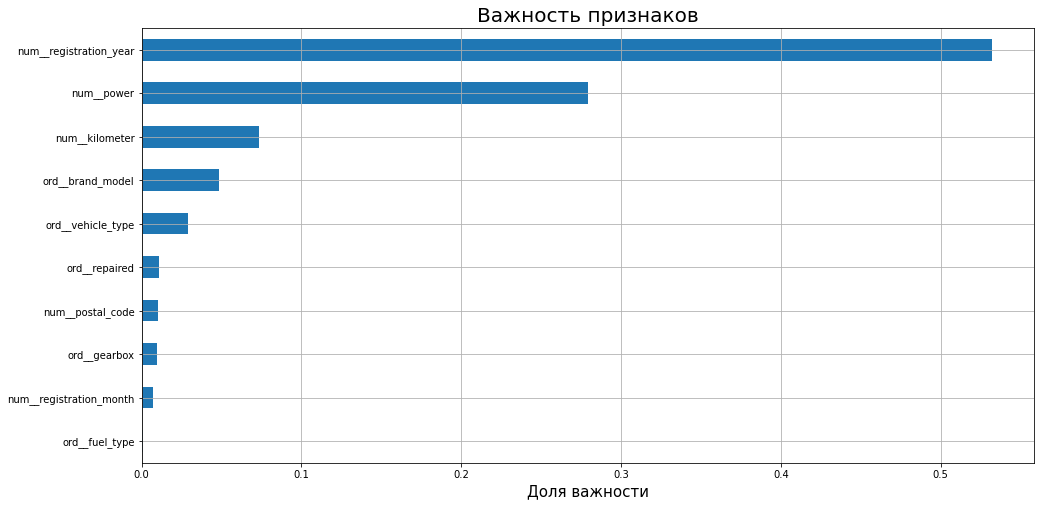

In [83]:
# построение графика важности признаков
fig, ax = plt.subplots(figsize=(16,8))
feature_importances_model_1.sort_values().plot.barh(grid=True)
plt.title('Важность признаков', fontsize=20)
plt.xlabel('Доля важности', fontsize=15)
plt.show()

На графике видно, что:
- самым важным признаком оказался год выпуска автомобиля `registration_year` (доля важности больше 0,5);
- дальше идет мощность автомобиля `power` (доля вжности почти 0,3);
- остальные признаки мало важны.

Получим предсказания и значение метрики `RMSE` на тестовой выборке лучшей модели:

In [84]:
# получение из пайплайна тестовой выборки
X_test_model_1 = pd.DataFrame(
    data_preprocessor.transform(X_test),
    columns=data_preprocessor.get_feature_names_out()    
)

In [85]:
# получение предсказаний
y_pred_model_best = model_1.predict(X_test_model_1)

In [86]:
print(f'Метрика RMSE на тестовой выборке: {round(root_mean_squared_error(y_test, y_pred_model_best), 2)}')

Метрика RMSE на тестовой выборке: 1906.06


Метрика получилась даже лучше, чем на валидационной выборке.

## Общий вывод

В данном проекте были построены три модели для определения стоимости автомобиля для сервиса по продаже автомобилей с пробегом «Не бит, не крашен».

В проекте проделана работа по изучению данных и их предобработке, а именно были:
- были изучены данные с помощью методов `info` и `describe`;
- названия столбцов приведены к змеиному регистру;
- обработаны пропуски в столбцах:
- обработаны аномальные значения в столбцах `price`, `registration_year`, `power`;
- из датафрйема убраны столбцы, не имеющие влияния на ценообразование:
- удалены явные дубликаты;
- категориальным признакам присвоен тип данных `category`.

Так же был проведен исследовательский и корреляционный анализ, где выявлено, что:
- в датафрейме представлены в основном не битые, бензиновые, с ручной КПП, в кузове `sedan`, `small` или `wagon` машины немецкого автопрома, с ценой до 6500, мощностью до 200 л.с., с пробегом 150000 км., с годом выпуска с 1999 по 2016;
- целевой признак `price` средне коррелирует с годом регистрации автомобиля `registration_year` (коэффициент Фи 0,677), немного меньше коррелируют признаки модель `model` и мощность `power` (коэффициент Фи 0,577 и 0,508 соответственно);
- дальше идет несколько признаков со слабой корреляцией: `vehicle_type`, `gearbox`, `kilometer`, `brand` и `repaired` (коэффицент корреляции Фи от 0,287 до 0,361);
- практически не коррелируют с целевым признаком: `registration_month`, `fuel_type` и `postal_code`.

Лучшей по критериям заказчика (качество предсказания, время обучения модели, время предсказания модели) стала модель: `DecisionTreeRegressor` с параметрами:
- максимальная глубина дерева `max_depth` - 15;
- максимальное число листьев `max_features` - none (не ограничено);
- минимальное число объектов в листе `min_samples_leaf` - 5;
- `RMSE` на тестовой выборке - 1906,06.